
IMPORTS:

In [14]:
import os
import sys
import cv2
import csv
import string

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from random import randrange
from tensorflow.keras import models
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Download data from drive to speed things up

In [0]:
zip_path = '/content/drive/My Drive/KNN/2017-IWT4S-CarsReId_LP-dataset.zip'
!cp "{zip_path}" .
!unzip -q -n '2017-IWT4S-CarsReId_LP-dataset.zip'

Parse csv and load train/test data

In [16]:
train_images = []
train_labels = []
test_images  = []
test_labels  = []

def add_blank_chars(label):
  empty_cnt = 8 - len(label)
  empty_c = ''
  for i in range(0, empty_cnt):
      empty_c += '#'
  second_part_beg = len(label) - 4
  new_end = empty_c + label[second_part_beg:]
  first_part_delim = 8 - len(new_end)
  return label[:first_part_delim] + new_end

with open('trainVal.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            # Skip header row
            line_count += 1
        else:
            label = ''
            if (len(row[2]) != 8):
                label = add_blank_chars(row[2])
            else:
                label = row[2]
            if int(row[3]) == 0:
                img = cv2.imread(row[1])
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                res = cv2.resize(img, dsize=(200, 40), interpolation=cv2.INTER_CUBIC)
                normalizedImg = np.zeros((200, 40))
                normalizedImg = cv2.normalize(res,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
                test_labels.append([label])
                test_images.append(normalizedImg)
            else:
                img = cv2.imread(row[1])
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                res = cv2.resize(img, dsize=(200, 40), interpolation=cv2.INTER_CUBIC)
                normalizedImg = np.zeros((200, 40))
                normalizedImg = cv2.normalize(res,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
                train_labels.append([label])
                train_images.append(normalizedImg)

train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)

img_train_part = train_images[:int(len(train_images) * .8)]
labels_train_part = train_labels[:int(len(train_labels) * .8)]
img_val_part = train_images[int(len(train_images) * .8):]
labels_val_part = train_labels[int(len(train_labels) * .8):]

# Debug
print(train_images.shape)
print(train_labels.shape)
print('')
print(img_train_part.shape)
print(labels_train_part.shape)
print('')
print(img_val_part.shape)
print(labels_val_part.shape)

(105924, 40, 200, 3)
(105924, 1)

(84739, 40, 200, 3)
(84739, 1)

(21185, 40, 200, 3)
(21185, 1)


Convert to 'loss function friendly' format

In [17]:
# Create dict to encode digits to numbers
y_map = {}
for i,d in enumerate(string.digits+string.ascii_uppercase + '#'):
    y_map[d] = i

# Utility function for split string in char and encode them
def split_encode(x):
    x = list(x[0])
    x = [y_map[d] for d in x]
    return x

# Transform target
train_labels = np.apply_along_axis(split_encode, 1, labels_train_part)
val_labels = np.apply_along_axis(split_encode, 1, labels_val_part)

# Debug
print(img_train_part.shape)
print(train_labels.shape)
print(img_val_part.shape)
print(val_labels.shape)

(84739, 40, 200, 3)
(84739, 8)
(21185, 40, 200, 3)
(21185, 8)


Class names A-Z, 0-9

Check few images

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


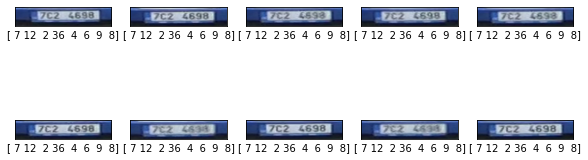

In [18]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_train_part[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

Create model

In [19]:
# 32,64,128 - filters count
# (x, x) is size of convolutional kernel
# relu is activation function
# batch normalization after each convolutional layer

from keras.layers import *

inp_dim = (40, 200, 3)
x_inp = Input(shape=inp_dim)

# First part
x = Conv2D(32, (3, 3), use_bias=False, padding='same')(x_inp)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(32, (3, 3), use_bias=False, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(32, (3, 3), use_bias=False, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(32, (3, 3), use_bias=False, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Second part
x = Conv2D(64, (3, 3), use_bias=False, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(64, (3, 3), use_bias=False, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(64, (3, 3), use_bias=False, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(64, (3, 3), use_bias=False, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Third part
x = Conv2D(128, (3, 3), use_bias=False, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(128, (3, 3), use_bias=False, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(128, (3, 3), use_bias=False, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(128, (3, 3), use_bias=False, padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x_out = Flatten()(x)
model = Model(x_inp, x_out)

branches = []

for i in range(8):
    x = Dense(128)(x_out)
    x = Dense(37)(x)
    x = Activation("linear")(x)
    branches.append(x)

final_model = Model(inputs = x_inp, outputs = branches)

# Display model architecture
final_model.summary()

# save model
model_json = final_model.to_json()
with open("/content/drive/My Drive/KNN/comb.json", "w") as json_file:
    json_file.write(model_json)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40, 200, 3)   0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 40, 200, 32)  864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 40, 200, 32)  128         conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 40, 200, 32)  0           batch_normalization_22[0][0]     
____________________________________________________________________________________________

In [0]:
from tensorflow.python.keras.utils.data_utils import Sequence

class ReIdSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.ys = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = [y[idx * self.batch_size:(idx + 1) * self.batch_size] for y in self.ys]

        return np.stack([
            self.augment(image=x)["image"] for x in batch_x
        ], axis=0), batch_y

In [0]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
                       val_shift_limit=10, p=.9),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
])

AUGMENTATIONS_TEST = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
                       val_shift_limit=10, p=.9),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
])

Compile and train the model

In [0]:
import functools

train_gen = ReIdSequence(
    img_train_part,
    [train_labels[:,i] for i in range(8)],
    32, 
    augmentations=AUGMENTATIONS_TRAIN
)

# Validation data
valid_gen = ReIdSequence(
    img_val_part,
    [val_labels[:,i] for i in range(8)],
    32,
    augmentations=AUGMENTATIONS_TEST
)

# Checkpoint callback (to save weights after each epoch)
filepath = "/content/drive/My Drive/KNN/aug/model-comb-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, logits_time_major=False, blank_index=-1, 
                 reduction=tf.keras.losses.Reduction.AUTO, name='ctc_loss'):
        super().__init__(reduction=reduction, name=name)
        self.logits_time_major = logits_time_major
        self.blank_index = blank_index

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        logit_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=None,
            logit_length=logit_length,
            logits_time_major=self.logits_time_major,
            blank_index=self.blank_index)
        return tf.reduce_mean(loss)

def train_step(self, data):
    data = data_adapter.expand_1d(data)
    x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)

    with tf.GradientTape() as tape:
        logits = self(x, training=True)
        logit_length = tf.fill([tf.shape(logits)[0]], tf.shape(logits)[1])
        loss = tf.nn.ctc_loss(
            labels=y,
            logits=logits,
            label_length=None,
            logit_length=logit_length,
            logits_time_major=False,
            blank_index=-1)
        loss = tf.reduce_mean(loss)
    trainable_variables = self.trainable_variables
    grads = tape.gradient(loss, trainable_variables)
    self.optimizer.apply_gradients(zip(grads, trainable_variables))
    return {'loss': loss}

# Adam optimizer with 0.001 learning rate
final_model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

final_model.train_step = functools.partial(train_step, final_model)

# Training
final_model.fit_generator(
    train_gen,
    epochs=80,
    validation_data=valid_gen,
    workers=2, use_multiprocessing=False,
    callbacks=[checkpoint])

Epoch 1/80
  91/2649 [>.............................] - ETA: 10:48 - loss: 88.1612 - activation_50_loss: 12.5320 - activation_51_loss: 10.1589 - activation_52_loss: 13.1136 - activation_53_loss: 0.0877 - activation_54_loss: 12.8934 - activation_55_loss: 13.1482 - activation_56_loss: 11.7624 - activation_57_loss: 14.4650 - activation_50_accuracy: 0.0000e+00 - activation_51_accuracy: 0.0000e+00 - activation_52_accuracy: 0.0161 - activation_53_accuracy: 3.4341e-04 - activation_54_accuracy: 0.1621 - activation_55_accuracy: 0.1192 - activation_56_accuracy: 0.0604 - activation_57_accuracy: 0.0735